In [ ]:
!pip install osmnx
!pip install gtfs_kit gdown
!pip install gtfs-segments

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 20.7 MB/s eta 0:00:00
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7591 sha256=1609cec76a8bcd595ec2a5d2b9f71345f553cb5a6d65f9dd55982190b1f982c1
  Stored in directory: /root/.cache/pip/wheels/ea/8b/96/b33d26a9d72d6c8ac50ef1fe81089c350a9fdcf51feab22144
Successfully built json2html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.3 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import osmnx as ox
import gtfs_kit as gk
import gdown
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from gtfs_segments import get_gtfs_segments

In [ ]:
#Descargar carpeta GTFS
file_id = '1NukBTyXyz92k6SbXGfxrX_VYs0r1ICjH'
output = 'afluencia.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

# Cargar el feed GTFS desde un archivo ZIP
feed = gk.read_feed(output, dist_units="m")

feed.stops.head()

Downloading...
From: https://drive.google.com/uc?id=1NukBTyXyz92k6SbXGfxrX_VYs0r1ICjH
To: /content/afluencia.zip
100%|██████████| 2.48M/2.48M [00:00<00:00, 30.0MB/s]


,stop_id,stop_name,stop_lat,stop_lon,zone_id,wheelchair_boarding
0,040010-TULIPAN,Tulipán,19.342902,-99.057158,040010-TULIPAN,1
1,01020A00-CIRGPRIETO,Circuito Interior - Guillermo Prieto,19.438267,-99.168144,01020A00-CIRGPRIETO,0
2,0501070-JBARRERA,Juan de la Barrera,19.509920,-99.188570,0501070-JBARRERA,0
3,0300L4-20NOVIEMBR,20 de Noviembre,19.429320,-99.134020,0300L4-MSCIUDAD,1
4,0300L4-PINOSRZSR,Pino Suárez Sur,19.426100,-99.134210,0300L4-20NOVIEMBR,1


In [ ]:
#Crear GeoDataFrame de los nodos de la gráfica
from shapely.geometry import Point

# Convertir stops a GeoDataFrame
gdf_nodes = gpd.GeoDataFrame(feed.stops.drop(columns=["zone_id", "wheelchair_boarding"]),
                             geometry=[Point(xy) for xy in zip(feed.stops.stop_lon, feed.stops.stop_lat)],
                             crs="EPSG:4326")

# Renombrar columnas para compatibilidad con OSMnx
gdf_nodes = gdf_nodes.rename(columns={"stop_id": "osmid", "stop_lon": "x", "stop_lat": "y"})
gdf_nodes = gdf_nodes.set_index("osmid")  # ID de nodo en el índice
gdf_nodes.head()

,stop_name,y,x,geometry
osmid,,,,
040010-TULIPAN,Tulipán,19.342902,-99.057158,POINT (-99.05716 19.3429)
01020A00-CIRGPRIETO,Circuito Interior - Guillermo Prieto,19.438267,-99.168144,POINT (-99.16814 19.43827)
0501070-JBARRERA,Juan de la Barrera,19.509920,-99.188570,POINT (-99.18857 19.50992)
0300L4-20NOVIEMBR,20 de Noviembre,19.429320,-99.134020,POINT (-99.13402 19.42932)
0300L4-PINOSRZSR,Pino Suárez Sur,19.426100,-99.134210,POINT (-99.13421 19.4261)


In [ ]:
#Crear GeoDataFrame de las aristas de la gráfica
from shapely.geometry import LineString

# Cargar secuencia de paradas desde stop_times.txt
stop_times = feed.stop_times.merge(feed.trips, on="trip_id").sort_values(["trip_id", "stop_sequence"])

edges_list = []
for trip_id, group in stop_times.groupby("trip_id"):
    stops = group.merge(feed.stops, on="stop_id").sort_values("stop_sequence")

    for i in range(len(stops) - 1):
        u, v = stops.iloc[i]["stop_id"], stops.iloc[i + 1]["stop_id"]
        geom = LineString([(stops.iloc[i]["stop_lon"], stops.iloc[i]["stop_lat"]),
                           (stops.iloc[i + 1]["stop_lon"], stops.iloc[i + 1]["stop_lat"])])
        edges_list.append({"u": u, "v": v, "key": 0, "geometry": geom, "route_id": stops.iloc[i]["route_id"]})

# Convertir a GeoDataFrame
gdf_edges = gpd.GeoDataFrame(edges_list, geometry="geometry", crs="EPSG:4326")
gdf_edges.head()

,u,v,key,geometry,route_id
0,0100C100-PERIFHOLI,010C1801-MAVILACONS,0,"LINESTRING (-99.22026 19.45289, -99.21932 19.4...",CMX01001A
1,010C1801-MAVILACONS,010C1301-PERIFELEGAR,0,"LINESTRING (-99.21932 19.44453, -99.21655 19.4...",CMX01001A
2,010C1301-PERIFELEGAR,010C1801-MAVILACEJNAL,0,"LINESTRING (-99.21655 19.44245, -99.21458 19.4...",CMX01001A
3,010C1801-MAVILACEJNAL,0100C100-PERIFHORACIO,0,"LINESTRING (-99.21458 19.43922, -99.21283 19.4...",CMX01001A
4,0100C100-PERIFHORACIO,0100C100-PERIFPALMAS,0,"LINESTRING (-99.21283 19.43577, -99.20912 19.4...",CMX01001A


In [ ]:
#Usar gtfs-segments para analizar todas las aristas del tranporte, obtener velocidades y tiempos
segments_df = get_gtfs_segments('/content/afluencia.zip')
#esto es para que corra en paralelo si se puede
segments_df = get_gtfs_segments("/content/afluencia.zip", parallel = True)
segments_df.head()

Using the busiest day: 2024-12-02


/usr/local/lib/python3.11/dist-packages/gtfs_segments/partridge_func.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_frame.fillna(False, inplace=True)


Excluding Trip: 01000Z1011_1 because of failed snap!
Excluding Trip: 01000Z1012_1 because of failed snap!
Excluding Trip: 010022D000_0 because of failed snap!
Excluding Trip: 0100Z4E000_1 because of failed snap!
Excluding Trip: 014009D000_1 because of failed snap!
Excluding Trip: 02100L9000_1 because of failed snap!
Excluding Trip: 03100L1002_0 because of failed snap!
Excluding Trip: 03100L1006_0 because of failed snap!
Excluding Trip: 03100L1006_1 because of failed snap!
Excluding Trip: 03100L4000_0 because of failed snap!
Excluding Trip: 03100L5004_0 because of failed snap!
Excluding Trip: 03100L5004_1 because of failed snap!
Excluding Trip: 031SEL1001_1 because of failed snap!
Excluding Trip: 034SEL1000_1 because of failed snap!
Excluding Trip: 04400L4000_1 because of failed snap!
Excluding Trip: 04400L8000_0 because of failed snap!
Excluding Trip: 051162B000_0 because of failed snap!
Excluding Trip: 051163A000_1 because of failed snap!
Excluding Trip: 051163B000_1 because of failed

/usr/local/lib/python3.11/dist-packages/gtfs_segments/partridge_func.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_frame.fillna(False, inplace=True)


:: Processing Feed in Parallel :: Number of cores: 2
Total trips processed: 25802
Total defective trips: 44
Percentage defective trips:0.17


,segment_id,route_id,direction_id,trip_id,traversals,distance,stop_id1,stop_id2,traversal_time,speed,geometry
0,0100C100-PERIF10OTE-0100C100-PERIFGRNSUR-1,CMX01001A,0.0,010001A000_0,1,512.39,0100C100-PERIF10OTE,0100C100-PERIFGRNSUR,115.0,4.455565,"LINESTRING (-99.16857 19.30188, -99.16852 19.3..."
1,0100C100-PERIF11ABRIL-0100C100-PERIFCALL4-1,CMX01001A,0.0,010001A000_0,1,470.50,0100C100-PERIF11ABRIL,0100C100-PERIFCALL4,105.0,4.480952,"LINESTRING (-99.18917 19.3953, -99.18915 19.39..."
2,0100C100-PERIFAGUILAS-0100C100-PERIFLORES-1,CMX01001A,0.0,010001A000_0,1,405.44,0100C100-PERIFAGUILAS,0100C100-PERIFLORES,91.0,4.455385,"LINESTRING (-99.19507 19.35827, -99.19511 19.3..."
3,0100C100-PERIFALENCAS-0100C100-PERIFERIACHA-1,CMX01001A,0.0,010001A000_0,1,1343.54,0100C100-PERIFALENCAS,0100C100-PERIFERIACHA,302.0,4.448808,"LINESTRING (-99.19905 19.42263, -99.199 19.422..."
4,0100C100-PERIFALTAVIS-0100C100-PERIFDESIERT-1,CMX01001A,0.0,010001A000_0,1,223.06,0100C100-PERIFALTAVIS,0100C100-PERIFDESIERT,50.0,4.461200,"LINESTRING (-99.20158 19.3492, -99.20159 19.34..."


In [ ]:
#Juntamos la inforómacin de segments_df con nuestro gdf_edges
#stop_times = feed.stop_times.merge(feed.trips, on="trip_id").sort_values(["trip_id", "stop_sequence"])
segments_df_drop = segments_df.drop(columns=["segment_id","route_id","direction_id","geometry"])
segments_df_drop = segments_df_drop.rename(columns={"stop_id1": "u", "stop_id2":"v"})
gdf_edges = gdf_edges.merge(segments_df_drop, on=["u", "v"])
gdf_edges = gdf_edges.rename(columns={"traversal_time":"travel_time", "distance":"length"})
gdf_edges.head()

,u,v,key,geometry,route_id,trip_id,traversals,length,travel_time,speed
0,0100C100-PERIFHOLI,010C1801-MAVILACONS,0,"LINESTRING (-99.22026 19.45289, -99.21932 19.4...",CMX01001A,010001A000_0,1,976.44,217.0,4.499724
1,010C1801-MAVILACONS,010C1301-PERIFELEGAR,0,"LINESTRING (-99.21932 19.44453, -99.21655 19.4...",CMX01001A,010001A000_0,1,377.64,85.0,4.442824
2,010C1301-PERIFELEGAR,010C1801-MAVILACEJNAL,0,"LINESTRING (-99.21655 19.44245, -99.21458 19.4...",CMX01001A,010001A000_0,1,416.73,93.0,4.480968
3,010C1801-MAVILACEJNAL,0100C100-PERIFHORACIO,0,"LINESTRING (-99.21458 19.43922, -99.21283 19.4...",CMX01001A,010001A000_0,1,424.54,95.0,4.468842
4,0100C100-PERIFHORACIO,0100C100-PERIFPALMAS,0,"LINESTRING (-99.21283 19.43577, -99.20912 19.4...",CMX01001A,010001A000_0,1,612.27,137.0,4.469124


In [ ]:
#Corregir índice del dataframe, hacer que tenga refererencias únicas
# Reset the index of gdf_edges
gdf_edges = gdf_edges.reset_index()

# Create a unique 'key' value for each edge
# Assuming 'u' and 'v' represent source and target node IDs:
gdf_edges['key'] = gdf_edges.groupby(['u', 'v']).cumcount()

# Set the index to a MultiIndex using 'u', 'v', and 'key'
gdf_edges = gdf_edges.set_index(['u', 'v', 'key'])
G1 = ox.graph_from_gdfs(gdf_nodes, gdf_edges)
gdf_edges.head()

,,,index,geometry,route_id,trip_id,traversals,length,travel_time,speed
u,v,key,,,,,,,,
0100C100-PERIFHOLI,010C1801-MAVILACONS,0,0,"LINESTRING (-99.22026 19.45289, -99.21932 19.4...",CMX01001A,010001A000_0,1,976.44,217.0,4.499724
010C1801-MAVILACONS,010C1301-PERIFELEGAR,0,1,"LINESTRING (-99.21932 19.44453, -99.21655 19.4...",CMX01001A,010001A000_0,1,377.64,85.0,4.442824
010C1301-PERIFELEGAR,010C1801-MAVILACEJNAL,0,2,"LINESTRING (-99.21655 19.44245, -99.21458 19.4...",CMX01001A,010001A000_0,1,416.73,93.0,4.480968
010C1801-MAVILACEJNAL,0100C100-PERIFHORACIO,0,3,"LINESTRING (-99.21458 19.43922, -99.21283 19.4...",CMX01001A,010001A000_0,1,424.54,95.0,4.468842
0100C100-PERIFHORACIO,0100C100-PERIFPALMAS,0,4,"LINESTRING (-99.21283 19.43577, -99.20912 19.4...",CMX01001A,010001A000_0,1,612.27,137.0,4.469124


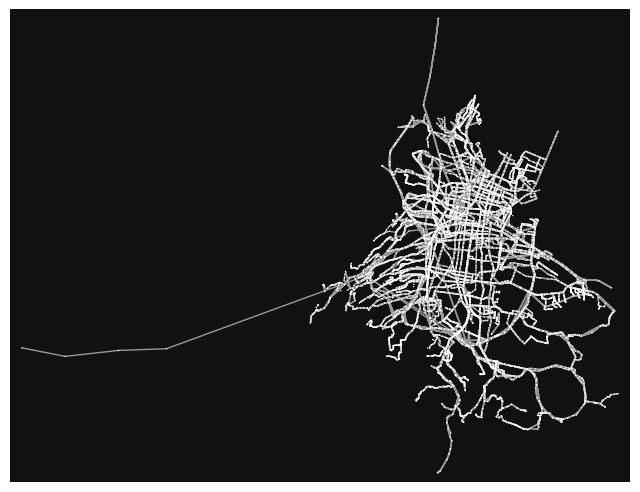

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Convertir a Gráfica de OSM
G1 = ox.graph_from_gdfs(gdf_nodes, gdf_edges)
ox.plot_graph(G1, node_size=1)

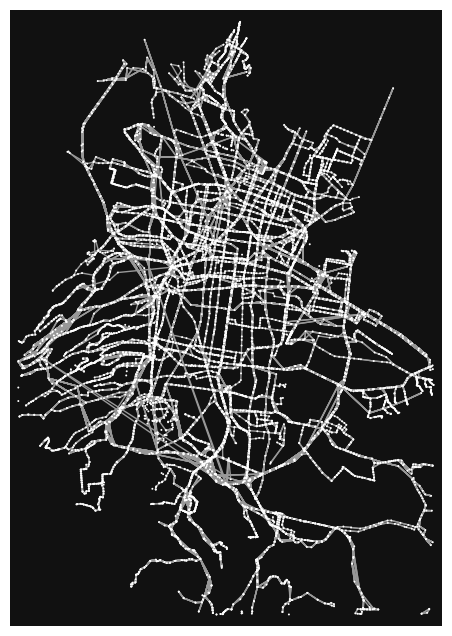

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
#Filtrar a un área reducida
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G1)
gdf_edges = gdf_edges.reset_index()
min_lat, min_lon = 19.2000, -99.2800
max_lat, max_lon = 19.5800, -99.0000
gdf_nodes = gdf_nodes.cx[min_lon:max_lon, min_lat:max_lat]
gdf_edges = gdf_edges[gdf_edges['u'].isin(gdf_nodes.index) & gdf_edges['v'].isin(gdf_nodes.index)]
gdf_edges = gdf_edges.set_index(['u', 'v', 'key'])
G1 = ox.graph_from_gdfs(gdf_nodes, gdf_edges)
ox.plot_graph(G1, node_size=2)

In [ ]:
#Simplificar gdf
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G1)
gdf_edges = gdf_edges.reset_index()
gdf_edges = gdf_edges.drop(columns=["traversals", "route_id", "trip_id"])
gdf_edges = gdf_edges.rename(columns={"index":"osmid"})
gdf_edges = gdf_edges.set_index(['u', 'v', 'key'])
G1 = ox.graph_from_gdfs(gdf_nodes, gdf_edges)
gdf_edges.head()


osmid  \
u                   v                    key          
0100C100-PERIFHOLI  010C1801-MAVILACONS  0        0   
010C1801-MAVILACONS 010C1301-PERIFELEGAR 0        1   
                    010C1801-MAVILACLEGA 0    34173   
                                         1    34174   
                                         2    34175   

                                                                                       geometry  \
u                   v                    key                                                      
0100C100-PERIFHOLI  010C1801-MAVILACONS  0    LINESTRING (-99.22026 19.45289, -99.21932 19.4...   
010C1801-MAVILACONS 010C1301-PERIFELEGAR 0    LINESTRING (-99.21932 19.44453, -99.21655 19.4...   
                    010C1801-MAVILACLEGA 0    LINESTRING (-99.21932 19.44453, -99.21647 19.4...   
                                         1    LINESTRING (-99.21932 19.44453, -99.21647 19.4...   
                                         2    LINESTRING (-99.21932 19.44453, -99.21647 19.4...   

                                              length  travel_time     speed  
u                   v                    key                                 
0100C100-PERIFHOLI  010C1801-MAVILACONS  0    976.44        217.0  4.499724  
010C1801-MAVILACONS 010C1301-PERIFELEGAR 0    377.64         85.0  4.442824  
                    010C1801-MAVILACLEGA 0    387.65         86.0  4.507558  
                                         1    387.65         86.0  4.507558  
                                         2    387.65         86.0  4.507558

In [ ]:
from shapely.geometry import Point
from shapely.geometry import LineString
from scipy.spatial import cKDTree
import numpy as np

#Conectamos nodos a 300 metros de distancia en la red de transporte existente para poder usar Dijistrak

gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G1)
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges)
next_osmid = 10_000_001

#Reproyectar el GeoDataFrame
gdf_nodes = gdf_nodes.to_crs("EPSG:6372")

# Suponiendo que tus nodos están en un GeoDataFrame `gdf_nodes`
coords = np.array([[geom.x, geom.y] for geom in gdf_nodes.geometry])
tree = cKDTree(coords)
pairs = tree.query_pairs(r=300) # 300 metros pues reproyectamos los nodos

# Puedes revisar cuántos pares se identifican
print(f"Se encontraron {len(pairs)} pares de estaciones cercanas.")

# Asumiendo que el grafo se llama G y que sus nodos tienen un atributo "geometry"
for i, j in pairs:
    node_i = gdf_nodes.iloc[i]
    node_j = gdf_nodes.iloc[j]

    # Calcular distancia euclideana (o usa geopy para más precisión)
    point_i = node_i.geometry
    point_j = node_j.geometry
    dist = point_i.distance(point_j)

    # Velocidad peatonal en m/s (≈4.5 km/h)
    velocidad = 4.5 * 1000 / 3600
    tiempo = dist / velocidad

    # Usar identificadores reales de los nodos
    u = node_i.name
    v = node_j.name

    linea = LineString([ (G.nodes[u]['x'], G.nodes[u]['y']),
                     (G.nodes[v]['x'], G.nodes[v]['y']) ])
    next_osmid += 1

    # Agregamos aritstas
    G.add_edge(u, v, length=dist, travel_time=tiempo, speed=velocidad, geometry=linea, osmid=next_osmid )


Se encontraron 49832 pares de estaciones cercanas.


In [ ]:
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)
gdf_edges.tail()

,,,osmid,geometry,length,travel_time,speed
u,v,key,,,,,
0501191-VCARRANZA,0501191-HGUADALAJARA,0,10045823,"LINESTRING (-99.22763 19.3713, -99.22692 19.37...",82.818401,66.254721,1.25
TRIOX0-EMBAJADORES,TRIOX0-HUALQUI,0,10034827,"LINESTRING (-99.09785 19.3761, -99.09893 19.3737)",288.061491,230.449193,1.25
COREV0-MERCEGOMEZ,COREV0-JUANTINOCO,0,10000989,"LINESTRING (-99.1888 19.36675, -99.18907 19.3647)",228.044829,182.435863,1.25
050115-MTACUBAYA,050115-MTACUBAYA1,0,10009449,"LINESTRING (-99.18733 19.40203, -99.18733 19.4...",0.000000,0.000000,1.25
CONGE1-MOCEANIA,0400L4-TRANSVAAL,0,10025487,"LINESTRING (-99.08694 19.44472, -99.08805 19.4...",230.167043,184.133634,1.25


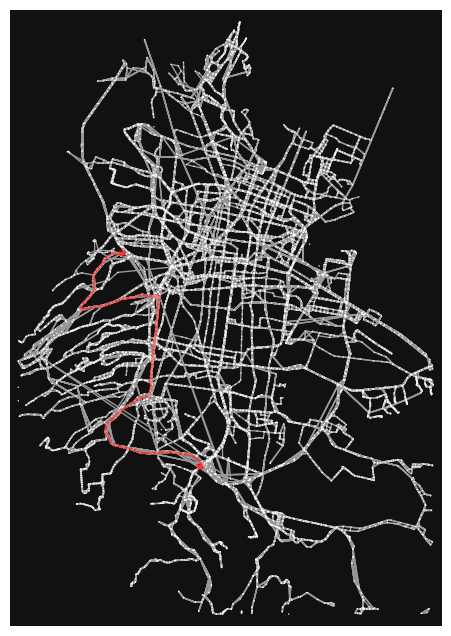

In [ ]:
#Prueba de que esta conectado correctamente G
#Selecciona puntos aleatorios y guarda rutas aleatorias
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)
gdf_nodes = gdf_nodes.reset_index()
rutas_g = []
for i in range(1):
    nodo1 = gdf_nodes.sample(1).iloc[0]
    nodo2 = gdf_nodes.sample(1).iloc[0]
    nombre1 = nodo1['osmid']
    nombre2 = nodo2['osmid']
    try:
        path = nx.shortest_path(G, source=nombre1, target=nombre2, weight="travel_time")
        rutas_g.append(path)
    except nx.NetworkXNoPath:
        print(f"No path found between {nombre1} and {nombre2}")

fig, ax = ox.plot_graph(G, node_size=1, show=False, close=False)
for path in rutas_g:
    fig, ax = ox.plot.plot_graph_route(G, path, route_color='r', route_linewidth=2, orig_dest_size=30, node_size=1, ax=ax, show=False, close=False)
plt.show()

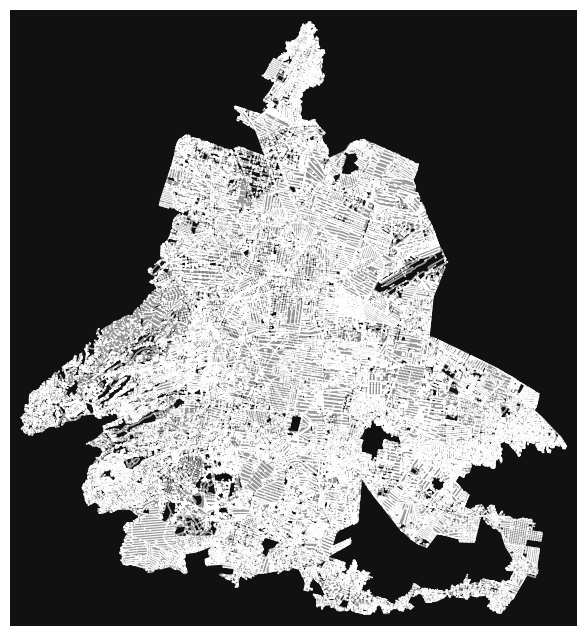

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Cargar el grafo de OSM para la ciudad para peatones
place_name = "Ciudad de México, México"
M = ox.graph_from_place(place_name, network_type="all")
ox.plot_graph(M, node_size=1)

In [ ]:
#Filtrar a un área reducida
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(M)
gdf_edges = gdf_edges.reset_index()
min_lat, min_lon = 19.2000, -99.2800
max_lat, max_lon = 19.5800, -99.0000
gdf_nodes = gdf_nodes.cx[min_lon:max_lon, min_lat:max_lat]
gdf_edges = gdf_edges[gdf_edges['u'].isin(gdf_nodes.index) & gdf_edges['v'].isin(gdf_nodes.index)]
gdf_edges = gdf_edges.set_index(['u', 'v', 'key'])
M = ox.graph_from_gdfs(gdf_nodes, gdf_edges)

In [ ]:
from google.colab import drive
# Unmount the drive first if it's already mounted
drive.flush_and_unmount()
# Remount the drive with force_remount=True to ensure a fresh mount
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
#Encontrar rutas en M desde los centros al estadio azteca usando Dijistrak
df = pd.read_csv("/content/drive/MyDrive/Hack_the_goal/Centros_CDMX/centros_bici.csv")
latitud_centros = df.iloc[:, 0].tolist()
longitud_centros = df.iloc[:, 1].tolist()

No path found between 1426389020 and 8218940298


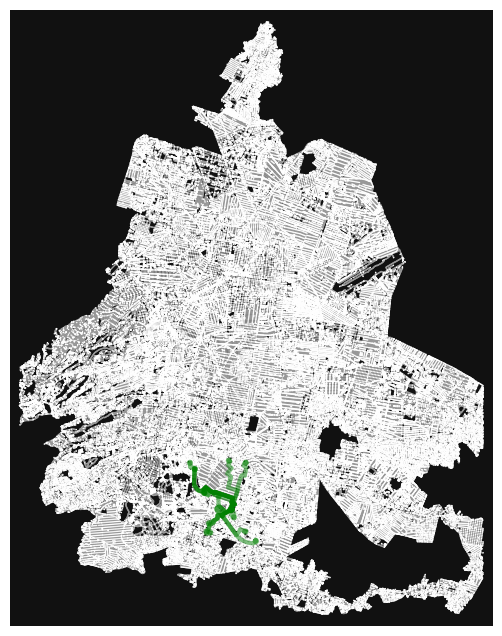

In [ ]:
#Selecciona puntos aleatorios al estadio y guarda rutas aleatorias
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(M)
gdf_nodes = gdf_nodes.reset_index()
ruta = []
dest = ox.distance.nearest_nodes(M, -99.152359, 19.301867) # Coordenadas del estadio azteca

for latitud, longitud in zip(latitud_centros, longitud_centros):

    orig = ox.distance.nearest_nodes(M, latitud, longitud) # Coordenadas del los centrtos obtenidad por cvs
    try:
        path = nx.shortest_path(M, source=orig, target=dest, weight="travel_time")
        ruta.append(path)
    except nx.NetworkXNoPath:
        print(f"No path found between {orig} and {dest}")

fig, ax = ox.plot_graph(M, node_size=1, show=False, close=False)
for path in ruta:
    fig, ax = ox.plot.plot_graph_route(M, path, route_color='g', route_linewidth=3, orig_dest_size=20, node_size=1, ax=ax, show=False, close=False)

plt.show()

In [ ]:
ruta_bici = []
ruta_bici = ruta

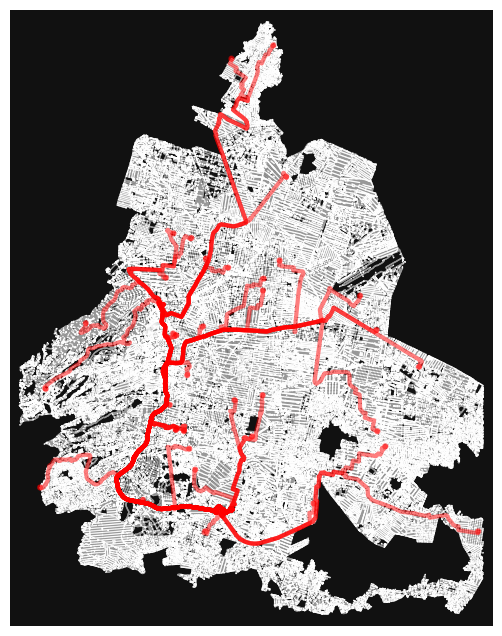

In [ ]:
#Encontrar rutas en M desde los centros al estadio azteca usando Dijistrak
df = pd.read_csv("/content/drive/MyDrive/Hack_the_goal/Centros_CDMX/centros_az.csv")
latitud_centros = df.iloc[:, 0].tolist()
longitud_centros = df.iloc[:, 1].tolist()

#Selecciona puntos aleatorios al estadio y guarda rutas aleatorias
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(M)
gdf_nodes = gdf_nodes.reset_index()
ruta = []
dest = ox.distance.nearest_nodes(M, -99.152359, 19.301867) # Coordenadas del estadio azteca

for latitud, longitud in zip(latitud_centros, longitud_centros):

    orig = ox.distance.nearest_nodes(M, latitud, longitud) # Coordenadas del los centrtos obtenidad por cvs
    try:
        path = nx.shortest_path(M, source=orig, target=dest, weight="travel_time")
        ruta.append(path)
    except nx.NetworkXNoPath:
        print(f"No path found between {orig} and {dest}")

fig, ax = ox.plot_graph(M, node_size=1, show=False, close=False)
for path in ruta:
    fig, ax = ox.plot.plot_graph_route(M, path, route_color='r', route_linewidth=3, orig_dest_size=20, node_size=1, ax=ax, show=False, close=False)

plt.show()

In [ ]:
print(ruta)
len(ruta)

[[280146001, 280146002, 280146003, 7518955514, 280146017, 280146018, 280146019, 8209047933, 8218840004, 796694516, 30384235, 7518955522, 8208867177, 319655058, 319654933, 8230822101, 888303279, 344814839, 344811278, 299609454, 299609456, 8204363662, 12661212504, 8204363673, 318077596, 8847014119, 8847014124, 12661212486, 290269029, 30384157, 290261923, 1408282283, 336977124, 290264027, 290262061, 290262088, 336963030, 343701703, 290262065, 336233882, 336233936, 336233779, 290263497, 3096265960, 1112512350, 7940168335, 275002183, 7940168329, 2335908365, 5824046127, 7960666666, 7960666645, 275029510, 275031858, 274980144, 7942905495, 274979571, 7939801315, 3113050397, 3113050392, 6175520939, 3112936883, 3112936914, 3112936900, 3113002900, 3113002899, 3113002875, 4602682713, 4638406088, 4602682711, 2372198198, 4602682715, 4638414447, 4638414445, 275053776, 8112046835, 275054615, 1135003158, 667173712, 275054301, 275054304, 8097687394, 275054308, 666081359, 666081358, 666020910, 666020887,

37

In [ ]:
#Ampliar la red de transporte dada una lista de las rutas complementarias

def expandir_rutas(G_base, rutas, G_fuente=None):
    """
    Amplía un grafo base con los nodos y aristas de varias rutas.

    Parámetros:
    - G_base: grafo original que se desea ampliar
    - rutas: lista de rutas, cada una una lista de nodos
    - G_fuente: grafo desde donde se copian los datos (por defecto, G_base)

    Retorna:
    - G_ampliado: grafo resultante
    - nodos_agregados: conjunto de nodos que fueron añadidos
    - aristas_agregadas: conjunto de tuplas (u, v) de aristas añadidas
    """
    G_ampliado = G_base.copy()
    G_fuente = G_fuente or G_base

    nodos_agregados = set()
    aristas_agregadas = set()

    for ruta in rutas:
        # Agregar nodos
        for node in ruta:
            if node not in G_ampliado.nodes:
                # If the node doesn't exist in G_base, add it with basic attributes
                # or attributes from G_fuente if available.
                if node in G_fuente.nodes:
                    G_ampliado.add_node(node, **G_fuente.nodes[node])
                else:
                    # If node is not in G_fuente, get its coordinates from M graph
                    nearest_node_data = ox.distance.nearest_nodes(M, node, return_dist=False)
                    # Assume M has 'x' and 'y' attributes
                    x = M.nodes[nearest_node_data]['x']
                    y = M.nodes[nearest_node_data]['y']
                    G_ampliado.add_node(node, x=x, y=y)  # Add with x, y attributes
                nodos_agregados.add(node)

        # Agregar aristas
        for u, v in zip(ruta[:-1], ruta[1:]):
            if not G_ampliado.has_edge(u, v):
                # Intenta obtener los datos de la arista de G_fuente si existe
                edge_data = G_fuente.get_edge_data(u, v, default={})

                # Si es MultiGraph, puede haber varias aristas
                if isinstance(edge_data, dict) and 0 in edge_data:
                    edge_data = edge_data[0]

                G_ampliado.add_edge(u, v, **edge_data)
                aristas_agregadas.add((u, v))

    return G_ampliado, nodos_agregados, aristas_agregadas


In [ ]:
#Simplificar, agregar velocidad y tiempo de translados al gdf
M = ox.routing.add_edge_speeds(M)
M = ox.routing.add_edge_travel_times(M)
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(M)
gdf_edges = gdf_edges.reset_index()
gdf_edges =  gdf_edges.drop(columns=["highway","name", "lanes", "oneway", "reversed", "ref", "tunnel", "bridge", "junction", "maxspeed", "width", "service", "access"])
gdf_edges = gdf_edges.rename(columns={"speed_kph":"speed"})
gdf_edges = gdf_edges.set_index(['u', 'v', 'key'])
gdf_nodes =  gdf_nodes.drop(columns=["highway", "street_count", "ref", "railway", "junction"])
M = ox.graph_from_gdfs(gdf_nodes, gdf_edges)
gdf_edges.head()

osmid      length  \
u          v           key                                                  
30339493   2353159027  0                            226529202  111.844417   
2353159027 274185917   0                            226529202   31.930108   
           2353159033  0    [217341594, 226522646, 226522647]   67.196284   
30339495   274187776   0                            226529202  119.143540   
           12061900269 0                            683249554   52.853334   

                                                                     geometry  \
u          v           key                                                      
30339493   2353159027  0    LINESTRING (-99.1341 19.41806, -99.13409 19.41...   
2353159027 274185917   0    LINESTRING (-99.13396 19.41905, -99.13392 19.4...   
           2353159033  0    LINESTRING (-99.13396 19.41905, -99.13387 19.4...   
30339495   274187776   0    LINESTRING (-99.13533 19.41027, -99.13517 19.4...   
           12061900269 0    LINESTRING (-99.13533 19.41027, -99.13483 19.4...   

                                speed  travel_time  
u          v           key                          
30339493   2353159027  0    69.052839     5.830896  
2353159027 274185917   0    69.052839     1.664644  
           2353159033  0    23.103448    10.470585  
30339495   274187776   0    69.052839     6.211428  
           12061900269 0    28.878861     6.588626

In [ ]:
#Usamos funcion para agregar rutas complementarias
G_nuevo, nuevos_nodos, nuevas_aristas = expandir_rutas(G, ruta, M)

# Visualizar nodos y aristas nuevas
print("Nodos nuevos:", nuevos_nodos)
print("Aristas nuevas:", nuevas_aristas)


Nodos nuevos: {1860632590, 275054615, 30384157, 7512260644, 4358897702, 8108875818, 3754827818, 275054640, 312672315, 683237436, 269287486, 4272439359, 6364004419, 2344493126, 884211783, 8167530571, 8435777614, 2372812888, 272195672, 5514289242, 5514289243, 8212119648, 8212119651, 8212119657, 30384235, 8212119660, 5514289268, 3688292469, 7952318582, 3469787259, 503726205, 8337940613, 268386440, 503726217, 2850480266, 268902541, 503726224, 6135357586, 503726228, 2850480287, 270606499, 268615845, 268615848, 3698122923, 2850480300, 3698122924, 345211054, 268386479, 268386476, 884211891, 884211893, 290767030, 503726264, 6093103289, 372949176, 884211899, 884211900, 372949183, 884211904, 274424005, 372949189, 372949196, 9279291597, 683237582, 8100315342, 8100315341, 7914348751, 8230822101, 2263294165, 6190350552, 8104239322, 670548187, 7939801315, 6255214820, 1865195750, 268386534, 6255214824, 5854503147, 6255214829, 6255214840, 1717633277, 6338527489, 290767107, 3113050392, 3113050397, 6255

In [ ]:
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G_nuevo)
gdf_edges.head()

osmid  \
u                  v                    key             
0100C100-PERIFHOLI 010C1801-MAVILACONS  0           0   
                   05057A0-AVILZAPADORE 0    10005497   
                   0100C101-BASE4CNOS   0    10008194   
                   010C1210-PERIFEVELAZ 0    10032624   
                   010C1800-MAVILACAV   0    10033389   

                                                                                      geometry  \
u                  v                    key                                                      
0100C100-PERIFHOLI 010C1801-MAVILACONS  0    LINESTRING (-99.22026 19.45289, -99.21932 19.4...   
                   05057A0-AVILZAPADORE 0    LINESTRING (-99.22026 19.45289, -99.22029 19.4...   
                   0100C101-BASE4CNOS   0    LINESTRING (-99.22026 19.45289, -99.21955 19.4...   
                   010C1210-PERIFEVELAZ 0    LINESTRING (-99.22026 19.45289, -99.21977 19.4...   
                   010C1800-MAVILACAV   0    LINESTRING (-99.22026 19.45289, -99.21977 19.4...   

                                                 length  travel_time     speed  
u                  v                    key                                     
0100C100-PERIFHOLI 010C1801-MAVILACONS  0    976.440000   217.000000  4.499724  
                   05057A0-AVILZAPADORE 0      8.340026     6.672021  1.250000  
                   0100C101-BASE4CNOS   0    152.842971   122.274377  1.250000  
                   010C1210-PERIFEVELAZ 0    180.717753   144.574202  1.250000  
                   010C1800-MAVILACAV   0    178.602226   142.881781  1.250000

In [ ]:
from shapely.geometry import Point
from shapely.geometry import LineString
from scipy.spatial import cKDTree
import numpy as np

#Conectamos nodos a 500 metros de distancia en la red de transporte existente para poder usar Dijistrak

gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G_nuevo)
next_osmid = 1000_000_001

#Reproyectar el GeoDataFrame
gdf_nodes = gdf_nodes.to_crs("EPSG:6372")

# Suponiendo que tus nodos están en un GeoDataFrame `gdf_nodes`
coords = np.array([[geom.x, geom.y] for geom in gdf_nodes.geometry])
tree = cKDTree(coords)
pairs = tree.query_pairs(r=500) # 500 metros pues reproyectamos los nodos

# Puedes revisar cuántos pares se identifican
print(f"Se encontraron {len(pairs)} pares de estaciones cercanas.")

# Asumiendo que el grafo se llama G y que sus nodos tienen un atributo "geometry"
for i, j in pairs:
    node_i = gdf_nodes.iloc[i]
    node_j = gdf_nodes.iloc[j]

    # Calcular distancia euclideana (o usa geopy para más precisión)
    point_i = node_i.geometry
    point_j = node_j.geometry
    dist = point_i.distance(point_j)

    # Velocidad peatonal en m/s (≈4.5 km/h)
    velocidad = 4.5 * 1000 / 3600
    tiempo = dist / velocidad

    # Usar identificadores reales de los nodos
    u = node_i.name
    v = node_j.name

    #linea = LineString([ (G.nodes[u]['x'], G.nodes[u]['y']),
     #                (G.nodes[v]['x'], G.nodes[v]['y']) ])
    next_osmid += 1

    # Agregamos aritstas
    G_nuevo.add_edge(u, v, length=dist, travel_time=tiempo, speed=velocidad, geometry=linea, osmid=next_osmid )




Se encontraron 153385 pares de estaciones cercanas.


In [ ]:
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G_nuevo)
gdf_edges.tail()

osmid  \
u          v          key               
8812144046 271959436  1    1000084488   
           8812144037 0    1000099956   
271959436  8812144037 0     654591560   
                      1    1000150581   
8812144037 8812144038 0     952057523   

                                                                    geometry  \
u          v          key                                                      
8812144046 271959436  1    LINESTRING (-99.18573 19.45192, -99.18582 19.4...   
           8812144037 0    LINESTRING (-99.18573 19.45192, -99.18582 19.4...   
271959436  8812144037 0    LINESTRING (-99.19546 19.43799, -99.1954 19.43...   
                      1    LINESTRING (-99.18573 19.45192, -99.18582 19.4...   
8812144037 8812144038 0     LINESTRING (-99.1954 19.43799, -99.1954 19.4381)   

                              length  travel_time      speed  
u          v          key                                     
8812144046 271959436  1     7.424188     5.939351   1.250000  
           8812144037 0     9.936178     7.948943   1.250000  
271959436  8812144037 0     6.623298     0.483892  49.275194  
                      1     6.613672     5.290938   1.250000  
8812144037 8812144038 0    12.285826     1.914388  23.103448

"for path in ruta:\n    fig, ax = ox.plot.plot_graph_route(G_nuevo, path, route_color='r', route_linewidth=3, orig_dest_size=20, node_size=1, ax=ax, show=False, close=False)\n\nplt.show()"

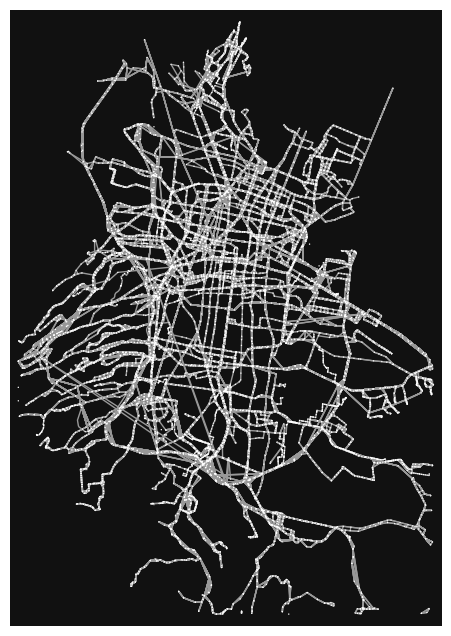

In [ ]:
fig, ax = ox.plot_graph(G_nuevo, node_size=1, show=False, close=False)
#fig, ax = ox.plot_graph(G_nuevo, node_size=1, edge_color='lightgray', show=False, close=False)
'''for path in ruta:
    fig, ax = ox.plot.plot_graph_route(G_nuevo, path, route_color='r', route_linewidth=3, orig_dest_size=20, node_size=1, ax=ax, show=False, close=False)

plt.show()'''

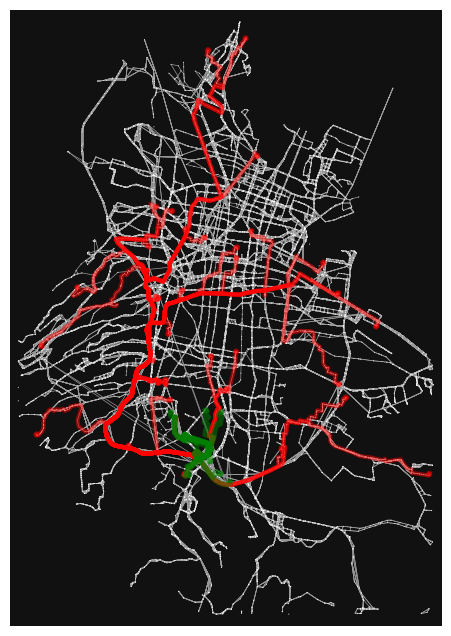

In [ ]:
fig, ax = ox.plot_graph(G_nuevo, edge_linewidth=.5, node_size=.5, show=False, close=False)
for path in ruta:
    ox.plot_graph_route(M, path, route_color='r', route_linewidth=3, orig_dest_size=20, node_size=1, ax=ax, show=False, close=False)
for path in ruta_bici:
    ox.plot_graph_route(M, path, route_color='g', route_linewidth=4, orig_dest_size=20, node_size=1, ax=ax, show=False, close=False)


plt.show()

In [ ]:
#Guardar carpeta en GraficasRedTransporte en nuestra carpeta compartida
#ox.io.save_graph_geopackage(G_nuevo, "G_nuevo_.gpkg")
#!cp G_nuevo.gpkg "/content/drive/MyDrive/Hack_the_goal/GraficasRedTransporte/"

In [ ]:
#Guardar carpeta en GraficasRedTransporte en nuestra carpeta compartida
ox.save_graphml(G_nuevo, filepath="G_nuevo_az.graphml") # Changed to ox.save_graphml, and corrected the file extension.
!cp G_nuevo_az.graphml "/content/drive/MyDrive/Hack_the_goal/GraficasRedTransporte/" #Updated file name to reflect the changes.

In [ ]:
import networkx as nx
from shapely.geometry import Point
from geopy.distance import geodesic

# Supongamos que cada nodo tiene atributos 'x' y 'y' (lon y lat)
#punto_referencia = (19.301867, -99.152359)  # (lat, lon)

def nodo_mas_cercano(G, punto_ref):
    return min(G.nodes, key=lambda n: geodesic((G.nodes[n]['y'], G.nodes[n]['x']), punto_ref).meters)

dest = nodo_mas_cercano(G_nuevo, (19.301867, -99.152359))
print(dest)


8218940298


In [ ]:
'''nodo_destacado = dest

# Dibuja el grafo
ox.plot_graph(
    G_nuevo,
    node_color=['red' if node == nodo_destacado else 'gray' for node in G_nuevo.nodes()],
    node_size=[50 if node == nodo_destacado else 1 for node in G_nuevo.nodes()],
    node_zorder=5,  # para que el nodo se dibuje encima de las aristas
    edge_color='lightblue',
    edge_linewidth=0.8,
)'''

"nodo_destacado = dest\n\n# Dibuja el grafo\nox.plot_graph(\n    G_nuevo,\n    node_color=['red' if node == nodo_destacado else 'gray' for node in G_nuevo.nodes()],\n    node_size=[50 if node == nodo_destacado else 1 for node in G_nuevo.nodes()],\n    node_zorder=5,  # para que el nodo se dibuje encima de las aristas\n    edge_color='lightblue',\n    edge_linewidth=0.8,\n)"

No path found in between


KeyError: '0100C80-REFBACATETE'

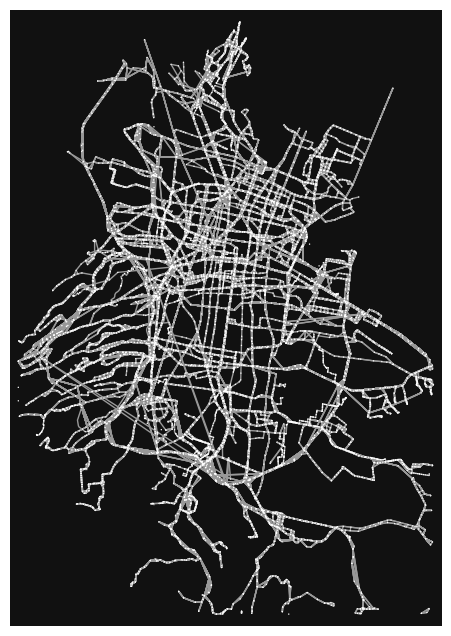

In [ ]:
#Prueba de que esta conectado correctamente G
#Selecciona puntos aleatorios y guarda rutas aleatorias
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G_nuevo)
gdf_nodes = gdf_nodes.reset_index()
rutas_g = []
for i in range(50):
    nodo1 = gdf_nodes.sample(1).iloc[0]
    nombre1 = nodo1['osmid']
    #dest = ox.distance.nearest_nodes(G_nuevo, -99.152359, 19.301867) # Coordenadas del estadio azteca
    try:
        path = nx.shortest_path(G_nuevo, source=nombre1, target=dest, weight="travel_time")
        rutas_g.append(path)
    except nx.NetworkXNoPath:
        print(f"No path found in between")

fig, ax = ox.plot_graph(G_nuevo, node_size=1, show=False, close=False)
for path in rutas_g:
    fig, ax = ox.plot.plot_graph_route(M, path, route_color='r', route_linewidth=3, route_alpha=0.5, orig_dest_size=20, node_size=1, ax=ax, show=False, close=False)

plt.show()

In [ ]:
'''
#Completa velocidad y tiempos de traslados
for u, v, k, data in M.edges(keys=True, data=True):
    data['speed_kph'] = 4.5  # Velocidad promedio al caminar 4.5 kph
M = ox.routing.add_edge_travel_times(M)

gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(M)
gdf_edges =  gdf_edges.drop(columns=["highway", "name", "lanes", "oneway", "reversed", "ref", "tunnel", "bridge", "junction", "maxspeed", "width", "service", "access"])
gdf_edges = gdf_edges.rename(columns={"speed_kph":"speed"})

gdf_edges.head()
'''

In [ ]:
'''
# get the nearest network node to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(M, -99.152359, 19.301867) # Coordenadas del estadio azteca
dest = ox.distance.nearest_nodes(M,  -99.148862, 19.403649) # Cualquier otras coordenadas

route = ox.routing.shortest_path(M, orig, dest, weight="travel_time" )
fig, ax = ox.plot.plot_graph_route(M, route, route_color='r', route_linewidth=1, orig_dest_size=1, node_size=1, route_alpha=1)
'''


In [ ]:
'''
print(f"Número de nodos original: {G.number_of_nodes()}")
print(f"Número de aristas original: {G.number_of_edges()}")
#Limpiar la gráfica
if G.is_directed():
    # Encuentra todos los componentes débilmente conectados (conjuntos de nodos)
    # Trata el grafo como no dirigido temporalmente para encontrar la conectividad básica
    components = nx.weakly_connected_components(G)
else:
    # Si tu grafo ya es no dirigido (Graph o MultiGraph)
    components = nx.connected_components(G)

# Encuentra el componente más grande (el conjunto de nodos con más elementos)
largest_cc_nodes = max(components, key=len)

# Crea un nuevo grafo (subgrafo) que contiene solo los nodos y aristas del componente más grande
G = G.subgraph(largest_cc_nodes).copy()

print(f"Número de nodos después de limpiar: {G.number_of_nodes()}")
print(f"Número de aristas después de limpiar: {G.number_of_edges()}")

ox.plot_graph(G, node_size=1)
'''

In [ ]:
'''
#Determina el Nodo mas cercano a las coordenadas dadas, parametros latitud y longitud
orig = ox.distance.nearest_nodes(G, -99.152359, 19.301867) # Coordenadas del estadio azteca
dest = ox.distance.nearest_nodes(G,  -99.148862, 19.313649) # Cualquier otras coordenadas
'''

In [ ]:
'''#Se tarda en ejecutar 1.5 horas con el mapa acotado a un rectangulo
# Cargar el grafo de OSM para la ciudad
place_name = "Ciudad de México, México"
M = ox.graph_from_place(place_name, network_type="all")


# Crear un diccionario para almacenar el mapeo de `stop_id` a `osmid`
node_correspondence = {}

for index, row in gdf_nodes.iterrows():
    lat, lon = row["y"], row["x"]
    nearest_node = ox.distance.nearest_nodes(M, X=lon, Y=lat)
    node_correspondence[row.name] = nearest_node
    '''

In [ ]:
#Crear GeoDataFrame de los nodos de la gráfica
# Actualiza la columna 'osmid' en gdf_nodes utilizando el diccionario
#gdf_nodes['osmid'] = gdf_nodes['stop_id'].map(stop_id_to_osmid)

# Verifica que la columna 'osmid' haya sido correctamente actualizada
#print(gdf_nodes[['stop_id', 'osmid']].head())